In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder


In [3]:
#Dataset path
dataset_path = './256_ObjectCategories'
all_images = glob.glob(f'{dataset_path}/*/*.jpg')
all_labels = [os.path.basename(os.path.dirname(img)) for img in all_images]

# Train-test split
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.167, random_state=50, stratify=all_labels)

In [4]:
img_size = 224  # VGG input size
batch_size = 32
NUM_CLASSES = 257

def data_generator(images, labels, batch_size, img_size, num_classes):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    
    while True:
        idx = np.random.permutation(len(images))
        for i in range(0, len(images), batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_images = [tf.keras.preprocessing.image.load_img(img, target_size=(img_size, img_size)) for img in np.array(images)[batch_idx]]
            batch_x = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in batch_images])
            batch_y = tf.keras.utils.to_categorical(encoded_labels[batch_idx], num_classes)
            
            yield batch_x, batch_y

train_generator = data_generator(train_images, train_labels, batch_size, img_size, NUM_CLASSES)
test_generator = data_generator(test_images, test_labels, batch_size, img_size, NUM_CLASSES)

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [22]:
#모델 빌드
from tensorflow.keras import layers, regularizers, optimizers, Model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.applications import VGG16

def build_model(num_classes):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # VGG16 모델 사용
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # 입력 레이어 추가
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    # 드롭아웃
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred",
                           kernel_regularizer=regularizers.l2(0.001),
                           activity_regularizer=regularizers.l1(0.001),
                           kernel_constraint=MaxNorm(2.))(x)
    
    # 학습률 감쇄 함수
    first_decay_steps = 500
    initial_lr = 5e-3 # 학습률 (1e-3|1e-4|1e-5)
    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=initial_lr, first_decay_steps=first_decay_steps))

    # Compile
    model = Model(inputs, outputs, name="VGG16")
    optimizer = optimizers.Adam(learning_rate=lr_decayed_fn)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

#모델 학습
model = build_model(num_classes=NUM_CLASSES)


In [23]:
epochs = 4

steps_per_epoch = len(train_images) // batch_size
validation_steps = len(test_images) // batch_size

hist1 = model.fit(train_generator, epochs=epochs,
                 validation_data=test_generator, steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps, verbose=1)
#plot_hist(hist1)

Epoch 1/4
796/796 [==============================] - 51s 63ms/step - loss: 2.7637 - accuracy: 0.5169 - val_loss: 2.2257 - val_accuracy: 0.6604
Epoch 2/4
796/796 [==============================] - 50s 63ms/step - loss: 2.1955 - accuracy: 0.6454 - val_loss: 2.1317 - val_accuracy: 0.6702
Epoch 3/4
796/796 [==============================] - 51s 63ms/step - loss: 2.4396 - accuracy: 0.6170 - val_loss: 2.0414 - val_accuracy: 0.7058
Epoch 4/4
796/796 [==============================] - 51s 64ms/step - loss: 1.9601 - accuracy: 0.6886 - val_loss: 1.7405 - val_accuracy: 0.7429


In [24]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen

    for layer in model.layers[-15:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
           
    first_decay_steps = 500
    initial_lr = 2e-5

    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=initial_lr, first_decay_steps=first_decay_steps))
    optimizer = keras.optimizers.Adam(learning_rate=lr_decayed_fn)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

epochs = 6
hist2 = model.fit(train_generator, epochs=epochs,
                 validation_data=test_generator, steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps, verbose=1)

Epoch 1/6
796/796 [==============================] - 97s 121ms/step - loss: 1.5777 - accuracy: 0.7579 - val_loss: 1.6119 - val_accuracy: 0.7592
Epoch 2/6
796/796 [==============================] - 96s 121ms/step - loss: 1.3753 - accuracy: 0.8091 - val_loss: 1.5702 - val_accuracy: 0.7736
Epoch 3/6
796/796 [==============================] - 96s 121ms/step - loss: 1.2856 - accuracy: 0.8295 - val_loss: 1.5392 - val_accuracy: 0.7887
Epoch 4/6
796/796 [==============================] - 97s 122ms/step - loss: 1.1036 - accuracy: 0.8805 - val_loss: 1.4594 - val_accuracy: 0.7991
Epoch 5/6
796/796 [==============================] - 97s 121ms/step - loss: 1.0595 - accuracy: 0.8936 - val_loss: 1.4930 - val_accuracy: 0.7854
Epoch 6/6
796/796 [==============================] - 94s 118ms/step - loss: 1.0367 - accuracy: 0.8976 - val_loss: 1.4574 - val_accuracy: 0.7926


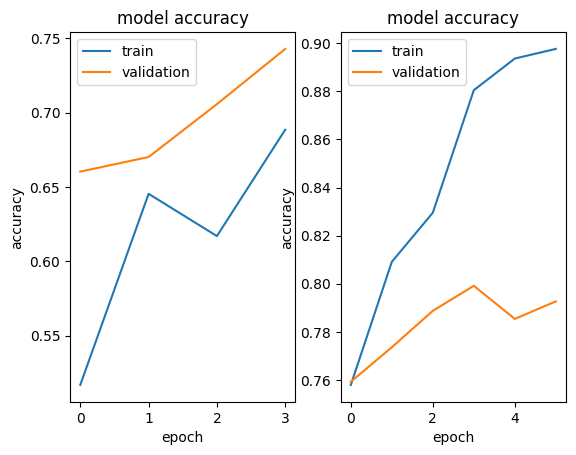

In [25]:
#시각화
plt.subplot(1,2,1)
plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(hist2.history["accuracy"])
plt.plot(hist2.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()